In [202]:
import cv2 as cv2
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import itertools as itertools 
import time
import os
import pandas as pd
import scipy.spatial as scipy_spatial
from skimage import color
import pickle
import sklearn
import cyvlfeat as vlfeat
import math
from scipy.spatial.distance import cdist
from sklearn.svm import LinearSVC, SVC
from utils import *
import random

Populating the interactive namespace from numpy and matplotlib


d:\1920sem1\cs4243\cs4243-lab3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'random', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [203]:
def all_files_in_dir(dir):
    return [os.path.join(dir, img) for img in os.listdir(dir) if os.path.isfile(os.path.join(dir, img))]

In [204]:
range_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range'
range_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square'

wenda_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda'
wenda_test_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test'
detected_wendas_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\detected_wendas'

wenda_waldo_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_waldo'
rubbish_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\rubbish'

In [205]:
wenda_squares = [os.path.join(wenda_square_save_dir, img) for img in os.listdir(wenda_square_save_dir) if os.path.isfile(os.path.join(wenda_square_save_dir, img))]

wenda_test_squares = [os.path.join(wenda_test_square_save_dir, img) for img in os.listdir(wenda_test_square_save_dir) if os.path.isfile(os.path.join(wenda_test_square_save_dir, img))]
wenda_waldo_squares = [os.path.join(wenda_waldo_square_save_dir, img) for img in os.listdir(wenda_waldo_square_save_dir) if os.path.isfile(os.path.join(wenda_waldo_square_save_dir, img))]
rubbish_squares = [os.path.join(rubbish_square_save_dir, img) for img in os.listdir(rubbish_square_save_dir) if os.path.isfile(os.path.join(rubbish_square_save_dir, img))]
not_wenda_squares =  wenda_waldo_squares + rubbish_squares

wenda_labels = ['wenda' for i in range(len(wenda_squares))]
wenda_waldo_labels = ['wenda_waldo' for i in range(len(wenda_waldo_squares))]
rubbish_labels = ['rubbish' for i in range(len(rubbish_squares))]
not_wenda_labels = ['not_wenda' for i in range(len(wenda_waldo_squares)+len(rubbish_squares))]

In [206]:
print(len(wenda_waldo_labels))
print(len(wenda_waldo_squares))
print(len(rubbish_labels))
print(len(rubbish_squares))


81
81
480
480


In [207]:
def build_vocabulary(image_paths, vocab_size):
    """
      This function will sample SIFT descriptors from the training images,
      cluster them with kmeans, and then return the cluster centers.

      Args:
      -   image_paths: list of image paths.
      -   vocab_size: size of vocabulary

      Returns:
      -   vocab: This is a vocab_size x d numpy array (vocabulary). Each row is a
          cluster center / visual word
    """
    # Load images from the training set. To save computation time, you don't
    # necessarily need to sample from all images, although it would be better
    # to do so. You can randomly sample the descriptors from each image to save
    # memory and speed up the clustering. Or you can simply call vl_dsift with
    # a large step size here, but a smaller step size in get_bags_of_sifts.
    #
    # For each loaded image, get some SIFT features. You don't have to get as
    # many SIFT features as you will in get_bags_of_sift, because you're only
    # trying to get a representative sample here. You can try taking 20 features
    # per image.
    #
    # Once you have tens of thousands of SIFT features from many training
    # images, cluster them with kmeans. The resulting centroids are now your
    # visual word vocabulary.

    dim = 128      # length of the SIFT descriptors that you are going to compute.
    vocab = np.zeros((vocab_size,dim))
    total_SIFT_features = np.zeros((20*len(image_paths), dim))

    #############################################################################
    # TODO: YOUR CODE HERE                                                      #
    #############################################################################

    # raise NotImplementedError('`build_vocabulary` function needs to be implemented')
    descriptor_collection = np.zeros((1, dim))
    sample_img_paths = image_paths
#     sample_img_paths = np.random.choice(image_paths, int(len(image_paths)/10))

    for i in range(len(sample_img_paths)):
    # for i in range(10):
        img = cv2.imread(sample_img_paths[i], 0)
        N = 50
        # N = 4
        step = max(int((img.shape[0] / N)), 1)
        size = 4
             
        frames, descriptors = vlfeat.sift.dsift(img, step=step, size=size)
        # print(descriptors.shape)
        # descriptors = descriptors[:21, :]
        descriptor_collection = np.vstack((descriptor_collection, descriptors))
        
    trimmed_descriptor_collection = descriptor_collection[1:,:]
    cluster_centers = vlfeat.kmeans.kmeans(trimmed_descriptor_collection, vocab_size)
    vocab = cluster_centers
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return vocab


In [208]:
vocab_filename = 'vocab.pkl'
if not os.path.isfile(vocab_filename):
    print('No existing visual word vocabulary found. Computing one from training images')
    vocab_size = 50  # Larger values will work better (to a point) but be slower to compute
    vocab = build_vocabulary(wenda_squares, vocab_size)
    
    with open(vocab_filename, 'wb') as f:
        pickle.dump(vocab, f)
        print('{:s} saved'.format(vocab_filename))

In [209]:
vocab.shape

(50, 128)

In [210]:
def bags_of_sifts(image_paths, vocab_filename):
    """
      You will want to construct SIFT features here in the same way you
      did in build_vocabulary() (except for possibly changing the sampling
      rate) and then assign each local feature to its nearest cluster center
      and build a histogram indicating how many times each cluster was used.
      Don't forget to normalize the histogram, or else a larger image with more
      SIFT features will look very different from a smaller version of the same
      image.

      Args:
      -   image_paths: paths to N images
      -   vocab_filename: Path to the precomputed vocabulary.
              This function assumes that vocab_filename exists and contains an
              vocab_size x 128 ndarray 'vocab' where each row is a kmeans centroid
              or visual word. This ndarray is saved to disk rather than passed in
              as a parameter to avoid recomputing the vocabulary every run.

      Returns:
      -   image_feats: N x d matrix, where d is the dimensionality of the
              feature representation. In this case, d will equal the number of
              clusters or equivalently the number of entries in each image's
              histogram (vocab_size) below.
    """
    # load vocabulary
    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

    # dummy features variable
    feats = []

    #############################################################################
    # TODO: YOUR CODE HERE                                                      #
    #############################################################################

    # raise NotImplementedError('`get_bags_of_sifts` function needs to be implemented')
    for i in range(len(image_paths)):
    # for i in range(10):
        img = cv2.imread(image_paths[i], 0)
        N = 50
        # N = 4
        step = max(int((img.shape[0] / N)), 1)
        size = 4
             
        frames, descriptors = vlfeat.sift.dsift(img, step=step, size=size)
        D = cdist(descriptors, vocab)
        indice_of_closest_vocab = np.argmin(D, axis=1)
        histogram = np.zeros(vocab.shape[0])
        for ind in indice_of_closest_vocab:
            histogram[ind] += 1
        normalized_histogram = normalize(histogram)
        feats.append(normalized_histogram)
        
    feats = np.array(feats)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return feats

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [211]:
def nearest_neighbor_classifier(train_image_feats, train_labels, test_image_feats,
    metric='euclidean'):
    """
      Args:
      -   train_image_feats:  N x d numpy array, where d is the dimensionality of
              the feature representation
      -   train_labels: N element list, where each entry is a string indicating
              the ground truth category for each training image
      -   test_image_feats: M x d numpy array, where d is the dimensionality of the
              feature representation. You can assume N = M, unless you have changed
              the starter code
      -   metric: (optional) metric to be used for nearest neighbor.
              Can be used to select different distance functions. The default
              metric, 'euclidean' is fine for tiny images. 'chi2' tends to work
              well for histograms

      Returns:
      -   test_labels: M element list, where each entry is a string indicating the
              predicted category for each testing image
    """
    test_labels = []

    #############################################################################
    # TODO: YOUR CODE HERE                                                      #
    #############################################################################
    D = cdist(test_image_feats, train_image_feats, metric=metric)
    indice_of_closest_vocab = np.argmin(D, axis=1)

    for ind in indice_of_closest_vocab:
            test_labels.append(train_labels[ind])
    # raise NotImplementedError('`nearest_neighbor_classify` function needs to be implemented')
    

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return test_labels


def svm_classify(train_image_feats, train_labels, test_image_feats):
    """
    This function will train a one-versus-one support vector machine (SVM)
    and then use the learned classifiers to predict the category of every test image. 

    Args:
    -   train_image_feats:  N x d numpy array, where d is the dimensionality of
            the feature representation
    -   train_labels: N element list, where each entry is a string indicating the
            ground truth category for each training image
    -   test_image_feats: M x d numpy array, where d is the dimensionality of the
            feature representation. You can assume N = M, unless you have changed
            the starter code
    Returns:
    -   test_labels: M element list, where each entry is a string indicating the
            predicted category for each testing image
    """
    categories = list(set(train_labels))
    test_labels = []

    #############################################################################
    # TODO: YOUR CODE HERE                                                      #
    #############################################################################
    
    # raise NotImplementedError('`svm_classify` function needs to be implemented')
    svm = SVC(C=1000)
    model = svm.fit(train_image_feats, train_labels)
    test_labels = model.predict(test_image_feats)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return test_labels

In [212]:
test_feats = bags_of_sifts(wenda_test_squares, 'vocab.pkl')

random_index = random.sample(range(len(rubbish_labels)), 200)
train_labels = wenda_labels + [rubbish_labels[i] for i in random_index]
train_imgs = wenda_squares + [rubbish_squares[i] for i in random_index]
# train_labels =  ['rubbish' for i in range(6)] + ['wenda'] + ['rubbish' for i in range(7, 15)]+ [rubbish_labels[i] for i in random_index]
# train_imgs = all_files_in_dir(detected_wendas_square_save_dir) + [rubbish_squares[i] for i in random_index]
train_feats = bags_of_sifts(train_imgs, 'vocab.pkl')
test_labels = svm_classify(train_feats, train_labels, test_feats)

d:\1920sem1\cs4243\cs4243-lab3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [213]:
print(test_labels)

['rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'wenda' 'wenda' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'wenda' 'rubbish' 'rubbish' 'rubbish'
 'wenda' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'wenda' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'wenda' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish' 'rubbish'
 'rubbish' 'rubbis

In [214]:
detected_wendas = [wenda_test_squares[i] for i in range(len(test_labels)) if test_labels[i]=='wenda']
print(len(detected_wendas))
print(detected_wendas)

22
['D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square0_58_range35_50.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square0_58_range36_70.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square0_68_range21_51.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square0_68_range31_49.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square1_58_range19_58.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square1_58_range24_40.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square1_58_range48_55.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square1_58_range7_37.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square1_68_range21_51.png', 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\wenda_test\\square1_68_rang

In [215]:
from shutil import copyfile

detected_wendas_square_save_dir = 'D:\\1920Sem1\\CS4243\\project_wx_tryout_code\\range_square\\detected_wendas'

for f in all_files_in_dir(detected_wendas_square_save_dir):
    os.remove(f)
    
count = 0
for detected_wenda in detected_wendas:
    copyfile(detected_wenda, os.path.join(detected_wendas_square_save_dir, str(count)+".png"))
    count += 1

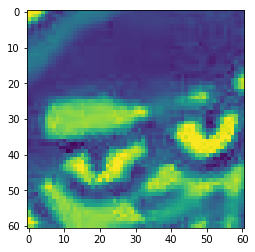

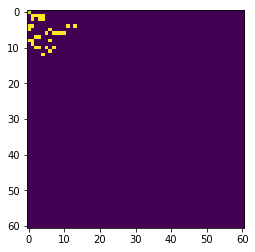

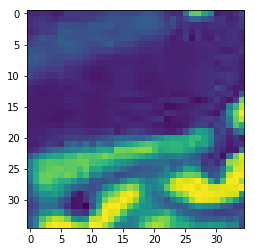

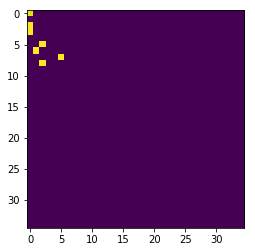

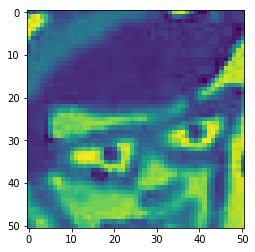

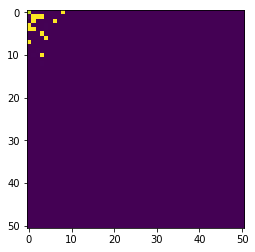

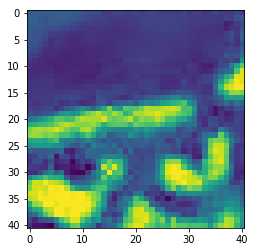

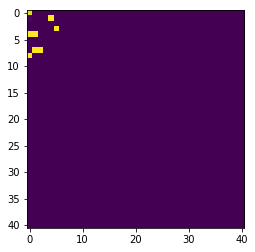

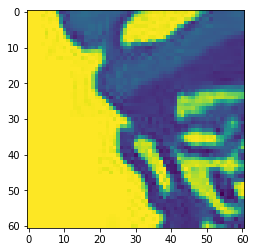

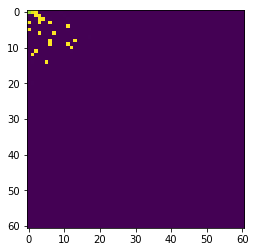

In [181]:
for i in range(5):
    a_wenda = cv2.imread(all_files_in_dir(wenda_square_save_dir)[i], 0)
    plt.imshow(a_wenda)
    plt.show()
    a_wenda_dct = cv2.dct(np.float32(a_wenda)/255.0)
    plt.imshow(np.uint8(a_wenda_dct)*255)
    plt.show()

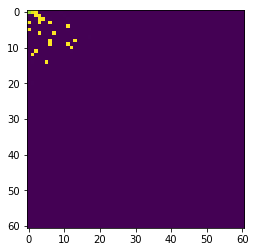

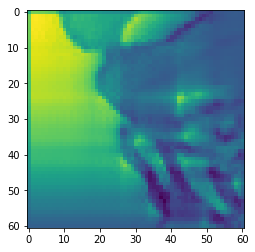

In [183]:
a_wenda_dct = cv2.dct(np.float32(a_wenda)/255.0)
plt.imshow(np.uint8(a_wenda_dct)*255)
plt.show()

a_wenda_back = cv2.dct(a_wenda_dct, cv2.DFT_INVERSE)
plt.imshow(a_wenda_back)
plt.show()

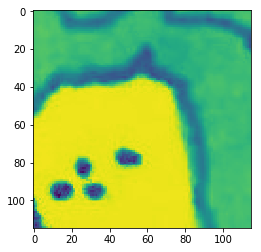

In [179]:
a_rubbish = cv2.imread(all_files_in_dir(rubbish_square_save_dir)[0], 0)
plt.imshow(a_rubbish)
plt.show()

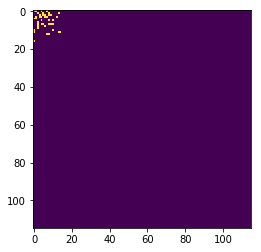

In [180]:
a_rubbish_dct = cv2.dct(np.float32(a_rubbish)/255.0)
plt.imshow(np.uint8(a_rubbish_dct)*255)
plt.show()